In [1]:
using Trapz, Cuba, BenchmarkTools, MathLink, Plots, DelimitedFiles, Distributions

# using beta function from mathematica
# beta0 = W"Beta"(W"z", W"a", W"b")
# beta(z, a, b) = weval(wbeta0; z=z, a=a, b=b)

In [2]:
m_min, m_max = 1e-1, 150.0

(0.1, 150.0)

In [3]:
function mergerRate(mergerRateDensity::Function)
    m_min, m_max = 1e-1, 150.0
    dm = m_max - m_min
    int(x, y) = dm^2 * mergerRateDensity(m_min + dm*x, m_min + dm*y)
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-1)
    result[1]

end

function cal_mid_up_low(xs)
    l, m, u = quantile(xs, [0.05, 0.5, 0.95])
    m, u - m, m - l
end

cal_mid_up_low (generic function with 1 method)

# lognormal

In [4]:
# log-normal mass function 
function mergerRateDensity1st0_log(mc, σc, log_fpbh, i, j)
    fpbh = 10^log_fpbh
    210084.52488130186 / (i^2 * j^2 * σc^2) * exp(-(743 * σc^4 + 1369 * log(i / mc)^2 + 1369 * log(j / mc)^2) / (2738 * σc^2)) * (i * j)^(3 / 37) * (i + j)^(36 / 37) * ((exp(σc^2 / 2) * fpbh) / mc)^(53 / 37) * mc^(53 / 37)
end

function mergerRateDensity2nd00_log(mc, σc, log_fpbh, i, j)
    fpbh = 10^log_fpbh
    tmp1 = 1009.5488113544313 * fpbh^(69 / 37) * i^(6 / 37) * (i + j)^(72 / 37) / j^(68 / 37) / σc^3
    tmp2 = exp(-(-3318 * σc^4 + 1369 * log(j / mc)^2) / (2738 * σc^2))

    int0(e) = exp(-(1369 * log(e / mc)^2 + 1369 * log((-e + i) / mc)^2) / (2738 * σc^2)) / (e^2 * (-e + i)^2)

    vx = range(1e-1, i - 1e-1, length=20)
    M = [int0(e) for e = vx]
    # @show M
    result = trapz((vx), M)

    # int(e) = i * int0(i * e)
    # function integrand(x, f)
    #     f[1] = int(x[1])
    # end
    # result, err = cuhre(integrand, rtol=1e-1)
    tmp1 * tmp2 * result[1]
end

function mergerRateDensity2nd0_log(mc, σc, log_fpbh, i, j)
    0.5 * (mergerRateDensity2nd00_log(mc, σc, log_fpbh, i, j) + mergerRateDensity2nd00_log(mc, σc, log_fpbh, j, i))
end

mergerRateDensity1st_log(mc, σc, log_fpbh, i, j) = mergerRateDensity1st0_log.(mc, σc, log_fpbh, i, j)
mergerRateDensity2nd_log(mc, σc, log_fpbh, i, j) = mergerRateDensity2nd0_log.(mc, σc, log_fpbh, i, j)

mergerRateDensity2nd_log (generic function with 1 method)

In [5]:
mc, σc, log_fpbh, i, j = 16.26, 0.75, -2.69, 30.0, 10.0;

In [6]:
function cal_R2_over_R1(mc, σc, log_fpbh)
    t1(i, j) = mergerRateDensity1st0_log(mc, σc, log_fpbh, i, j)
    t2(i, j) = mergerRateDensity2nd0_log(mc, σc, log_fpbh, i, j)
    R1, R2 = mergerRate(t1), mergerRate(t2)
    R1 + R2, R2 / R1
end

cal_R2_over_R1(mc, σc, log_fpbh)

(54.710190026617234, 0.011062963437915246)

In [7]:
post = readdlm("H0_GWTC-3_PBH-lognormal-2nd_flatLCDM_2/dynesty_samples.dat")
mcs = post[2:end, 1]
σcs = post[2:end, 2]
log_fpbhs = post[2:end, 3];

R12s = zeros(size(post)[1] - 1)
R2_to_R1s = zeros(size(post)[1] - 1)
for i in 2:size(post)[1]
    mc, σc, log_fpbh = post[i, :]
    R12, R2_over_R1 = cal_R2_over_R1(mc, σc, log_fpbh)
    R12s[i-1] = R12
    R2_to_R1s[i-1] = R2_over_R1
end

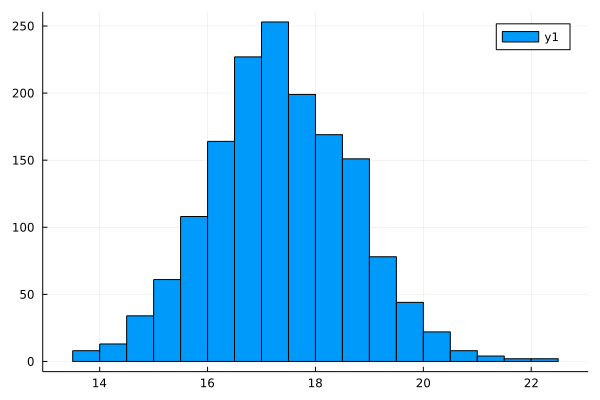

In [8]:
histogram(mcs)

In [9]:
cal_mid_up_low(mcs)

(17.31060950152863, 2.214250623140142, 2.0465150350053793)

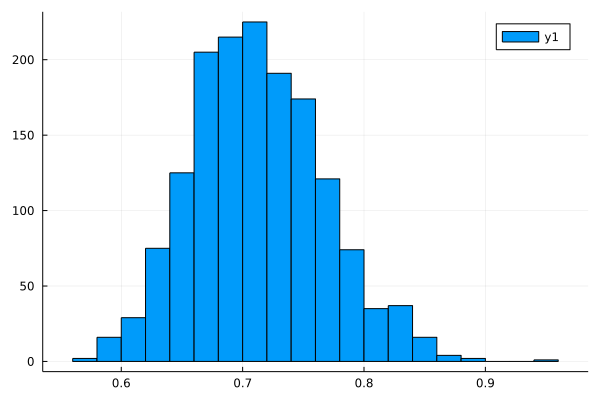

In [10]:
histogram(σcs)

In [11]:
cal_mid_up_low(σcs)

(0.708743863834724, 0.09859546321303203, 0.07848575052600681)

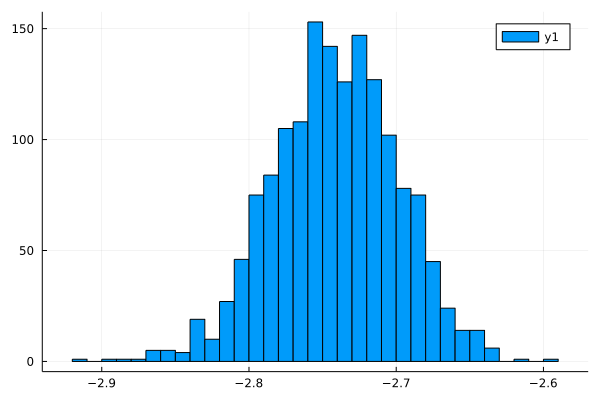

In [12]:
histogram(log_fpbhs)

In [13]:
cal_mid_up_low(10 .^ log_fpbhs .* 1e3)

(1.8166614596243296, 0.3042892548595164, 0.2632728337604229)

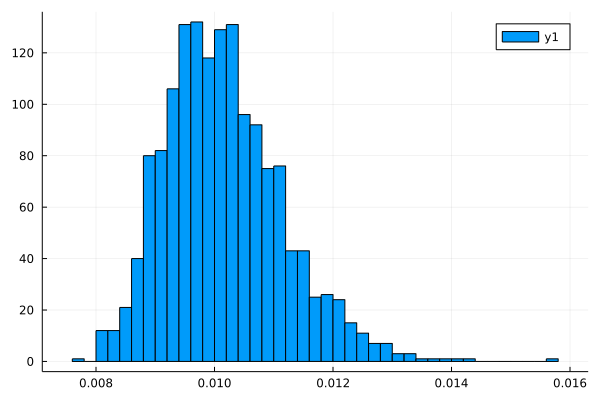

In [14]:
histogram(R2_to_R1s)

In [15]:
cal_mid_up_low(R2_to_R1s .* 1e2)

(1.007259196087493, 0.19240440826486926, 0.12973328470176515)

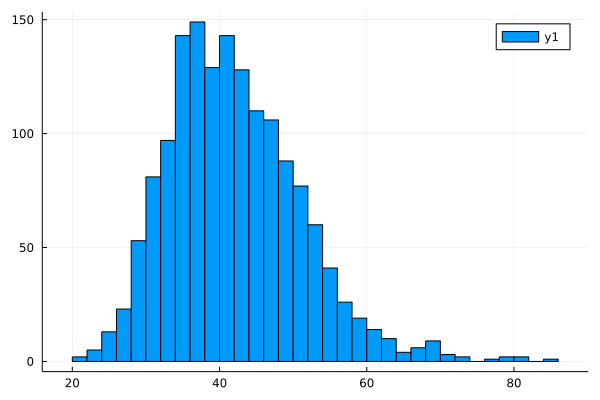

In [16]:
histogram(R12s)

In [17]:
cal_mid_up_low(R12s)

(41.25103816045193, 16.146576433847564, 11.908294431070946)

# power-law

In [18]:
α, M, log_fpbh, i, j = 1.92, 6.23, -2.59, 30, 10;

In [19]:
function mergerRateDensity1st0_power(α, M, log_fpbh, i, j)
    if (i > M) & (j > M)
        fpbh = 10^log_fpbh
        numerator = 4.884e7 * (i + j)^(36 / 37) * (i / M)^(-α) * (j / M)^(-α) * (fpbh * (-1 + α) / (M * α))^(53 / 37) * α^3
        denominator = (i * j)^(34 / 37) * M^(21 / 37) * (21.0 + 37.0 * α)
        numerator / denominator
    else
        0
    end
end

mergerRateDensity1st0_power(α, M, log_fpbh, i, j)

0.02484814980649504

In [20]:
# function mergerRateDensity2nd00_power1(α, M, log_fpbh, i, j)
#     if i > 2 * M
#         fpbh = 10^log_fpbh
#         t1 = 588300.0 / ((i * j)^(31 / 37) * (42.0 + 37.0 * α)) * i^(-2 * α) * j^(-α) * (i + j)^(72 / 37)
#         t2 = M^(-3 + 3α) * ((fpbh * (-1 + α)) / α)^(69 / 37) * α^4
#         t3 = -wbeta(M / i, -α, -α) + wbeta(1 - M / i, -α, -α)
#         t1 * t2 * t3
#     else
#         0
#     end
# end

function mergerRateDensity2nd00_power(α, M, log_fpbh, i, j)
    if (i > 2 * M) & (j>M)
        fpbh = 10^log_fpbh
        t1 = 588300.0 * i^(6 / 37) * (i + j)^(72 / 37) * ((fpbh * (-1 + α)) / (M * α))^(69 / 37) * α^4 * M^(3 * α)
        t2 = j^(31 / 37) * M^(42 / 37) * (42 + 37α)

        int0(e) = (e * (-e + i) * j)^-α / e / (-e + i)

        vx = range(M, i - M, length=20)
        M = [int0(e) for e = vx]
        # @show M
        result = trapz((vx), M)

        # int(e) = i * int0(i * e)
        # function integrand(x, f)
        #     f[1] = int(x[1])
        # end
        # result, err = cuhre(integrand, rtol=1e-1)
        t1 / t2 * result[1]
    else
        0.0
    end
end

function mergerRateDensity2nd0_power(α, M, log_fpbh, i, j)
    0.5 * (mergerRateDensity2nd00_power(α, M, log_fpbh, i, j) + mergerRateDensity2nd00_power(α, M, log_fpbh, j, i))
end

mergerRateDensity1st_power(α, M, log_fpbh, i, j) = mergerRateDensity1st0_power.(α, M, log_fpbh, i, j)
mergerRateDensity2nd_power(α, M, log_fpbh, i, j) = mergerRateDensity2nd0_power.(α, M, log_fpbh, i, j)

mergerRateDensity2nd_power (generic function with 1 method)

In [21]:
mergerRateDensity2nd00_power(α, M, log_fpbh, i, j), mergerRateDensity2nd00_power(α, M, log_fpbh, j, i)

(0.0006102892277625077, 0.0)

In [22]:
function cal_R2_over_R1_power(α, M, log_fpbh)
    t1(i, j) = mergerRateDensity1st0_power(α, M, log_fpbh, i, j)
    t2(i, j) = mergerRateDensity2nd0_power(α, M, log_fpbh, i, j)
    R1, R2 = mergerRate(t1), mergerRate(t2)
    R1 + R2, R2 / R1
end

cal_R2_over_R1_power(α, M, log_fpbh)

(64.04002872475276, 0.009484900381804624)

In [23]:
post = readdlm("H0_GWTC-3_PBH-power-2nd_flatLCDM_2//dynesty_samples.dat")
αs = post[2:end, 1]
Ms = post[2:end, 2]
log_fpbhs = post[2:end, 3]

R12s = zeros(size(post)[1] - 1)
R2_to_R1s = zeros(size(post)[1] - 1)
for i in 2:size(post)[1]
    α, M, log_fpbh = post[i, :]
    R12, R2_over_R1 = cal_R2_over_R1_power(α, M, log_fpbh)
    R12s[i-1] = R12
    R2_to_R1s[i-1] = R2_over_R1
end

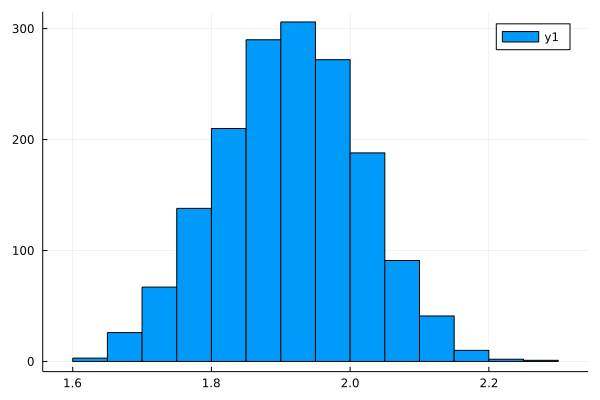

In [24]:
histogram(αs)

In [25]:
cal_mid_up_low(αs)

(1.9115234035597806, 0.1721128073153042, 0.16881923238875896)

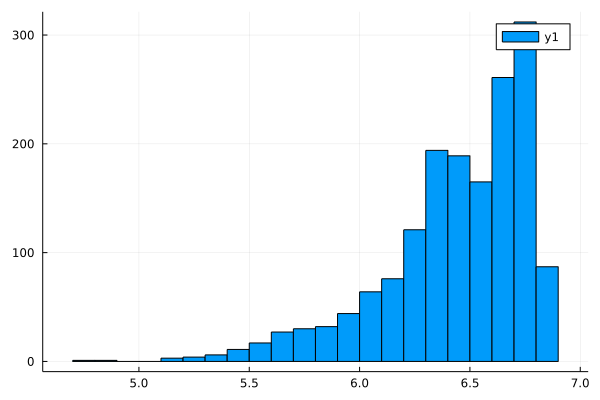

In [26]:
histogram(Ms)

In [27]:
cal_mid_up_low(Ms)

(6.5020619270578806, 0.29886333146110644, 0.764132797973744)

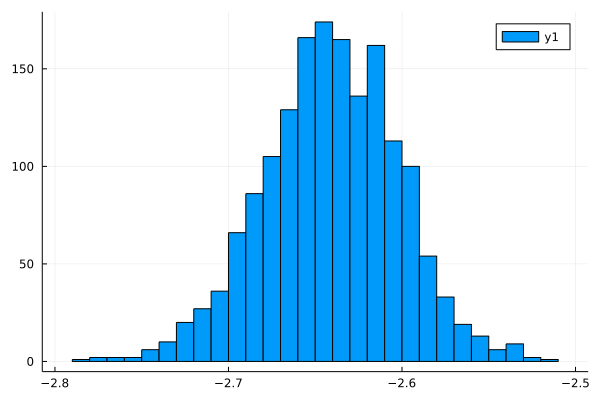

In [28]:
histogram(log_fpbhs)

In [29]:
cal_mid_up_low(10 .^ log_fpbhs .* 1e3)

(2.287957515903448, 0.34357441858057003, 0.31599529919266867)

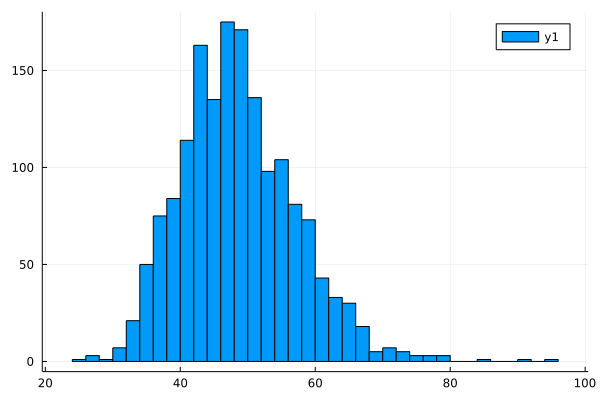

In [30]:
histogram(R12s)

In [31]:
cal_mid_up_low(R12s)

(47.91689733057212, 15.386899561611486, 11.967008200130529)

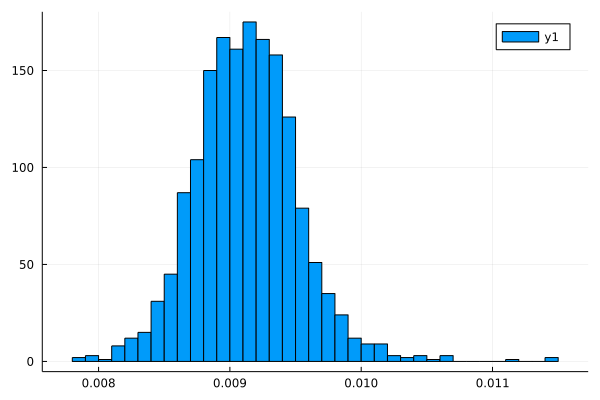

In [32]:
histogram(R2_to_R1s)

In [33]:
cal_mid_up_low(R2_to_R1s .* 1e2)

(0.911898129823347, 0.06426353358700276, 0.0592657353746433)

# broken power-law

In [34]:
ms, α1, α2, log_fpbh, i, j = 8.89, 3.05, 2.07, -2.62, 30, 10

(8.89, 3.05, 2.07, -2.62, 30, 10)

In [35]:
function piecewise(i, ms, α1, α2)
    (i < ms) ? (i / ms)^α1 : (i / ms)^(-α2)
end

piecewise (generic function with 1 method)

In [36]:
# function mergerRateDensity1st0_bpower(ms, α1, α2, log_fpbh, i, j)
#     if α1 > 21 / 37
#         fpbh = 10.0^log_fpbh
#         t1 = 1.32e6 * fpbh * (i + j)^(36 / 37) * α1^2.0 * (1.0 + α1) * (-1 + α2) * (fpbh * (1 + α1) * (-1 + α2) / ms / α1 / α2)^(16 / 37) * α2^2.0
#         t2 = (i * j)^(34 / 37) * ms^(58 / 37) * (-0.567568 + α1) * (α1 + α2)^2.0 * (0.567568 + α2)
#         t1 * piecewise(i, ms, α1, α2) * piecewise(j, ms, α1, α2) / t2
#     else
#         0.0
#     end
# end
# mergerRateDensity1st0_bpower(ms, α1, α2, log_fpbh, 20, j)

In [37]:
function mergerRateDensity1st0_bpower(ms, α1, α2, log_fpbh, i, j)
    fpbh = 10.0^log_fpbh
    t1 = 3.5832299e7 * 10^(-α1 - 3 * α2) * fpbh * (i + j)^(36 / 37) * ms^(-58 / 37 - α1) * α1^2 * (1.0 + α1) * (-1.0 + α2)
    t2 = (fpbh * (1 + α1) * (-1 + α2) / ms / α1 / α2)^(16 / 37) * α2^2
    t31 = 10^α1 * ms^(21 / 37 + α1 + α2) * (-0.567568 + α1) + 10^(α1 + 3 * α2) * ms^α1 * (-50.4316 * α1 - 50.4316 * α2)
    t32 = 1000.0^α2 * ms^(21 / 37) * (105.752 + 186.325 * α2)
    t4 = (i * j)^(34 / 37) * (-21 + 37 * α1) * (α1 + α2)^3 * (21 + 37 * α2)
    -t1 * t2 * (t31 + t32) * piecewise(i, ms, α1, α2) * piecewise(j, ms, α1, α2) / t4
end


mergerRateDensity1st0_bpower(ms, α1, α2, log_fpbh, i, j)

0.03056176111246792

In [38]:
mergerRateDensity1st0_bpower(ms, 11/37, α2, log_fpbh, i, j)

0.01836342215487518

In [39]:

# function mergerRateDensity2nd00_bpower(ms, α1, α2, log_fpbh, i, j)
#     if α1 > 42 / 37
#         fpbh = 10.0^log_fpbh

#         t1 = 2.17671e7 * i^(6 / 37) * (i + j)^(72 / 37) * α1^4 * (fpbh * (1 + α1) * (-1 + α2) / ms / α1 / α2)^(69 / 37) * α2^4
#         t2 = j^(31 / 37) * ms^(42 / 37) * (1 + α1)^3 * (-42 + 37 * α1) * (1 / (1 + α1) + 1 / (-1 + α2))^3 * (-1 + α2)^3 * (42 + 37α2)

#         int0(e) = piecewise(e, ms, α1, α2) * piecewise(i - e, ms, α1, α2) / e / (-e + i)

#         vx = range(0+1e-10, i-1e-10, length=20)
#         M = [int0(e) for e = vx]
#         # @show M
#         result = trapz((vx), M)

#         # int(e) = i * int0(i * e)
#         # function integrand(x, f)
#         #     f[1] = int(x[1])
#         # end
#         # result, err = cuhre(integrand, rtol=1e-1)
#         t1 * piecewise(j, ms, α1, α2) * result[1] / t2
#     else
#         0.0
#     end
# end
# mergerRateDensity2nd00_bpower(ms, α1, α2, log_fpbh, i, j)

In [40]:
function mergerRateDensity2nd00_bpower(ms, α1, α2, log_fpbh, i, j)

    fpbh = 10.0^log_fpbh

    t1 = 8558.45 * 10^(-α1 - 3 * α2) * fpbh * i^(6 / 37) * (i + j)^(72 / 37) * ms^(-79 / 37 - α1) * α1^3 * (1 + α1) * (-1 + α2)
    t2 = (fpbh * (1 + α1) * (-1 + α2) / ms / α1 / α2)^(32 / 37) * α2^3
    t31 = 10^α1 * ms^(42 / 37 + α1 + α2) * (-1.13514 + α1)
    t32 = 10^(α1 + 3 * α2) * ms^α1 * (-2543.35 * α1 - 2543.35 * α2)
    t33 = 1000^α2 * ms^(42 / 37) * (39408.3 + 34716.9 * α2)
    t4 = j^(31 / 37) * (-42.0 + 37.0 * α1) * (α1 + α2)^4 * (42.0 + 37.0 * α2)

    int(e) = piecewise(e, ms, α1, α2) * piecewise(i - e, ms, α1, α2) / e / (-e + i)

    ve = range(m_min, i - 1e-5, length=20)
    Ie = trapz((ve), int.(ve))

    -t1 * t2 * (t31 + t32 + t33) * piecewise(j, ms, α1, α2) / t4 * Ie
end


mergerRateDensity2nd00_bpower(ms, α1, α2, log_fpbh, i, j)

0.0008319069429246843

In [41]:
ms, α1, α2, 10^log_fpbh, i, j, 2

(8.89, 3.05, 2.07, 0.00239883291901949, 30, 10, 2)

In [42]:
function mergerRateDensity2nd0_bpower(ms, α1, α2, log_fpbh, i, j)
    0.5 * (mergerRateDensity2nd00_bpower(ms, α1, α2, log_fpbh, i, j) + mergerRateDensity2nd00_bpower(ms, α1, α2, log_fpbh, j, i))
end

mergerRateDensity1st_bpower(ms, α1, α2, log_fpbh, i, j) = mergerRateDensity1st0_bpower.(ms, α1, α2, log_fpbh, i, j)
mergerRateDensity2nd_bpower(ms, α1, α2, log_fpbh, i, j) = mergerRateDensity2nd0_bpower.(ms, α1, α2, log_fpbh, i, j)

mergerRateDensity2nd_bpower (generic function with 1 method)

In [43]:
function cal_R2_over_R1_bpower(ms, α1, α2, log_fpbh)
    t1(i, j) = mergerRateDensity1st0_bpower(ms, α1, α2, log_fpbh, i, j)
    t2(i, j) = mergerRateDensity2nd0_bpower(ms, α1, α2, log_fpbh, i, j)
    R1, R2 = mergerRate(t1), mergerRate(t2)
    R1 + R2, R2 / R1
end

cal_R2_over_R1_bpower(ms, α1, α2, log_fpbh)

(56.249545625089375, 0.00975054756895325)

In [44]:
post = readdlm("H0_GWTC-3_PBH-bpower-2nd_flatLCDM_5//dynesty_samples.dat")
mss = post[2:end, 1]
α1s = post[2:end, 2]
α2s = post[2:end, 3]
log_fpbhs = post[2:end, 4]

R12s = zeros(size(post)[1] - 1)
R2_to_R1s = zeros(size(post)[1] - 1)
for i in 2:size(post)[1]
    ms, α1, α2, log_fpbh = post[i, :]
    R12, R2_over_R1 = cal_R2_over_R1_bpower(ms, α1, α2, log_fpbh)
    R12s[i-1] = R12
    R2_to_R1s[i-1] = R2_over_R1
end

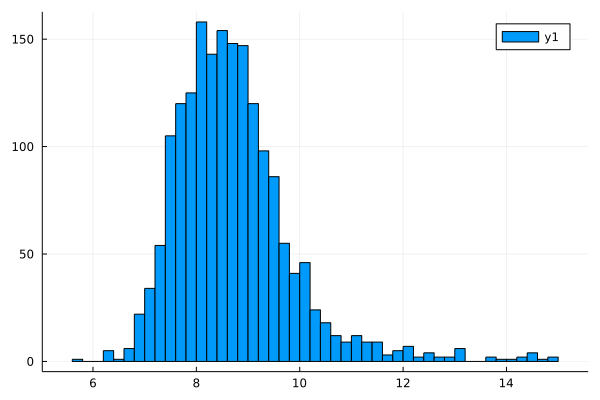

In [45]:
histogram(mss)

In [46]:
cal_mid_up_low(mss)

(8.577761574382968, 2.1495897417843945, 1.2869388530857746)

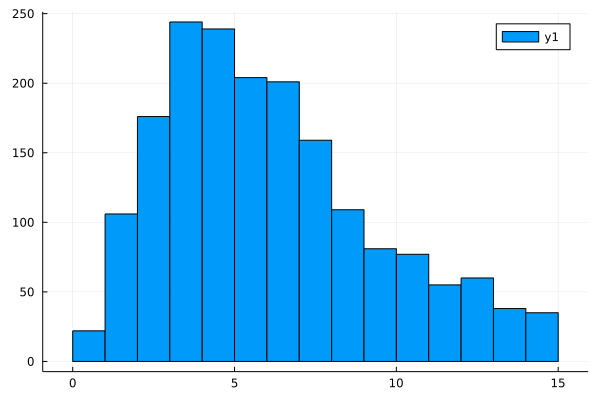

In [47]:
histogram(α1s)

In [48]:
cal_mid_up_low(α1s)

(5.580436222522744, 7.123537126525241, 3.815197259824316)

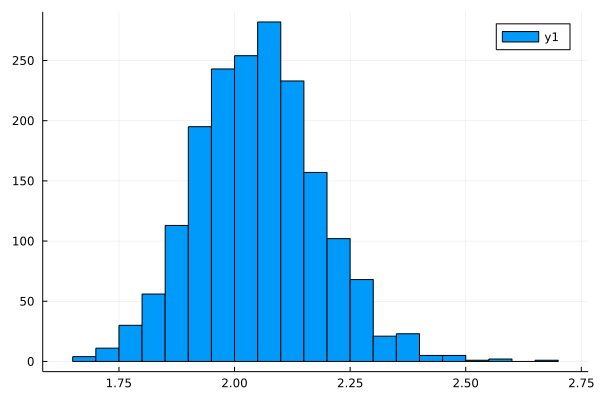

In [49]:
histogram(α2s)

In [50]:
cal_mid_up_low(α2s)

(2.0493970562483588, 0.21835913085030167, 0.20964424697635398)

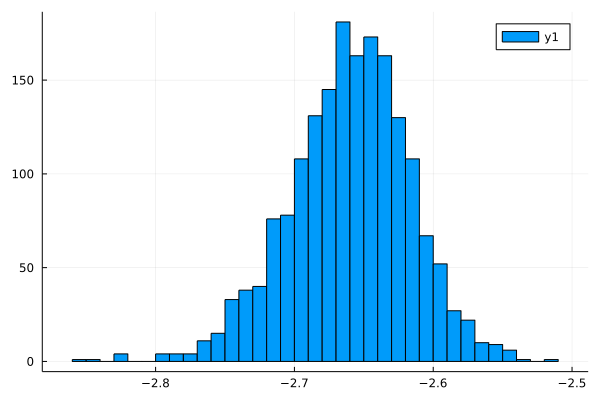

In [51]:
histogram(log_fpbhs)

In [52]:
cal_mid_up_low(10 .^ log_fpbhs .* 1e3)

(2.195526998562136, 0.34946259379741473, 0.3611890568338154)

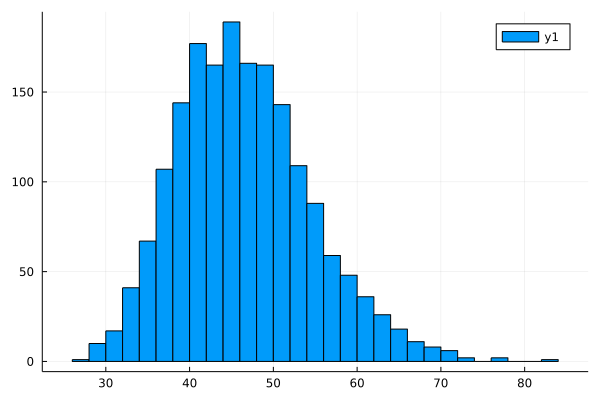

In [53]:
histogram(R12s)

In [54]:
cal_mid_up_low(R12s)

(45.88591948113027, 15.293124548748935, 11.345474726710776)

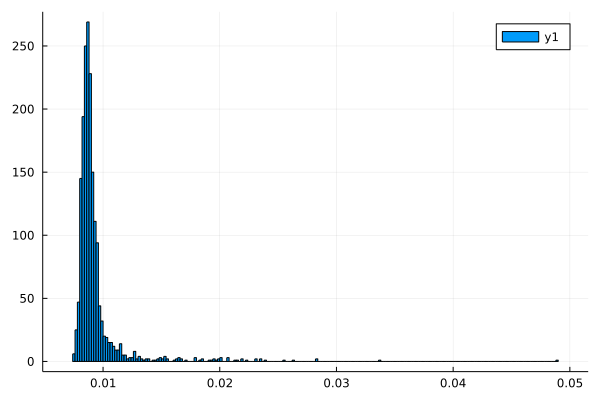

In [55]:
histogram(R2_to_R1s)

In [56]:
cal_mid_up_low(R2_to_R1s .* 1e2)

(0.8775992360480327, 0.3153777748086164, 0.07399418603851327)

# CC

In [57]:
using SpecialFunctions

In [58]:
α, Mf, log_fpbh, i, j = 0.92, 9.34, -2.88, 30, 10

(0.92, 9.34, -2.88, 30, 10)

In [59]:
# function mergerRateDensity1st0_CC(α, Mf, log_fpbh, i, j)
#     if α > 21/37
#     fpbh = 10^log_fpbh
#     t1 = 1.32e6 * exp(-(i / Mf)^α - (j / Mf)^α) * (i * j)^α * (i + j)^(36 / 37) * (i * j)^(-34 / 37)
#     t2 = Mf^(-21 / 37 - 2 * α) * α^2 * gamma(1 - 21 / 37 / α) * (fpbh * α / Mf / gamma(1 / α))^(53 / 37)

#     t1 * t2
#     else
#         0.0
#     end
# end
# mergerRateDensity1st0_CC(α, Mf, log_fpbh, i, j)

In [60]:
gamma(0.899, 2.0)

0.12171212330069098

In [61]:
m_min, m_max = 1e-1, 1e3;

In [62]:
# function mergerRateDensity1st0_CC(α, Mf, log_fpbh, i, j)
#     fpbh = 10^log_fpbh
#     t1 = 1.32e6 * exp(-(i / Mf)^α - (j / Mf)^α) * (i * j)^α * (i + j)^(36 / 37) * (i * j)^(-34 / 37)
#     t2 = Mf^(-3 * α) * α^3 * (fpbh * α / Mf / gamma(1 / α))^(53 / 37) 

#     int(l) = exp(-(l / Mf)^α) * l^(-(58 / 37) + α)
#     vl = range(m_min, m_max, length=500)
#     I = trapz((vl), int.(vl))
#     t1 * t2 * I
# end


# mergerRateDensity1st0_CC(α, Mf, log_fpbh, i, j)

In [63]:
function mergerRateDensity1st0_CC(α, Mf, log_fpbh, i, j)
    fpbh = 10^log_fpbh
    t1 = (i * j)^(-34 / 37) * 1.32e6 * exp(-(i / Mf)^α - (j / Mf)^α) * i^α * j^α * (i + j)^(36 / 37) * Mf^(-(21 / 37) - 2 * α) * α^2
    t2 = (fpbh * α / Mf / gamma(1 / α))^(53 / 37) * (gamma(1 - 21 / 37 / α, (10.0 * Mf)^(-α)) - gamma(1 - 21 / 37 / α, (1e-3 * Mf)^(-α)))
    t1 * t2
end


mergerRateDensity1st0_CC(α, Mf, log_fpbh, i, j)

0.017960862797137912

In [64]:
@btime mergerRateDensity1st0_CC(α, Mf, log_fpbh, i, j)

  718.938 ns (1 allocation: 16 bytes)


0.017960862797137912

In [65]:
mergerRateDensity1st0_CC(0.1, Mf, log_fpbh, i, j)

9.465392834721715e-14

In [66]:

# function mergerRateDensity2nd00_CC(α, Mf, log_fpbh, i, j)
#     if α > 42 / 37
#         fpbh = 10^log_fpbh

#         tmp1 = 15900.0 * i^(6 / 37) * j^(-(31 / 37) + α) * (i + j)^(72 / 37) * Mf^(-(42 / 37) - 3 * α) * α^3
#         tmp2 = gamma(1 - 42 / 37 / α) * (fpbh * α / Mf / gamma(1 / α))^(69 / 37)

#         int0(e) = e^(-1 + α) * exp(-(e / Mf)^α - ((-e + i) / Mf)^α - (j / Mf)^α) * (-e + i)^(-1 + α)

#         vx = range(0, i, length=20)
#         M = [int0(e) for e = vx]
#         # @show M
#         result = trapz((vx), M)

#         # int(e) = i * int0(i * e)
#         # function integrand(x, f)
#         #     f[1] = int(x[1])
#         # end
#         # result, err = cuhre(integrand, rtol=1e-1)
#         tmp1 * tmp2 * result[1]
#     else
#         0.0
#     end
# end
# mergerRateDensity2nd00_CC(α, Mf, log_fpbh, i, j)

In [67]:
# function mergerRateDensity2nd00_CC(α, Mf, log_fpbh, i, j)
#     fpbh = 10^log_fpbh

#     t1 = 15900.0 * i^(6 / 37) * j^(-(31 / 37) + α) * (i + j)^(72 / 37)
#     t2 = Mf^(-4 * α) * α^4 * exp(-(j / Mf)^α) * (fpbh * α / Mf / gamma(1 / α))^(69 / 37)

#     int1(e) = e^(-1 + α) * exp(-(e / Mf)^α - ((-e + i) / Mf)^α) * (-e + i)^(-1 + α)
#     int2(l) = l^(-(79 / 37) + α)exp(-(l / Mf)^α)

#     ve = range(m_min, i - 1e-5, length=20)
#     vl = range(m_min, m_max, length=20)
#     I1 = trapz((ve), int1.(ve))
#     I2 = trapz((vl), int2.(vl))

#     t1 * t2 * I1 * I2
# end

# mergerRateDensity2nd00_CC(α, Mf, log_fpbh, i, j)

In [68]:
function mergerRateDensity2nd00_CC(α, Mf, log_fpbh, i, j)
    fpbh = 10^log_fpbh

    t1 = 15900.0 * i^(6 / 37) * j^(-(31 / 37) + α) * (i + j)^(72 / 37) * Mf^(-(42 / 37) - 3 * α) * α^3
    t2 = (fpbh * α / Mf / gamma(1 / α))^(69 / 37) * (gamma(1 - 42 / 37 / α, (10.0 * Mf)^-α) - gamma(1 - 42 / 37 / α, (1e-3 * Mf)^(-α)))

    int1(e) = e^(-1 + α) * exp(-(e / Mf)^α - ((-e + i) / Mf)^α - (j / Mf)^α) * (-e + i)^(-1 + α)

    ve = range(m_min, i - 1e-5, length=20)
    Ie = trapz((ve), int1.(ve))

    t1 * t2 * Ie
end

mergerRateDensity2nd00_CC(α, Mf, log_fpbh, i, j)

0.0007629383279362727

In [69]:
function mergerRateDensity2nd0_CC(α, Mf, log_fpbh, i, j)
    0.5 * (mergerRateDensity2nd00_CC(α, Mf, log_fpbh, i, j) + mergerRateDensity2nd00_CC(α, Mf, log_fpbh, j, i))
end

mergerRateDensity1st_CC(α, Mf, log_fpbh, i, j) = mergerRateDensity1st0_CC.(α, Mf, log_fpbh, i, j)
mergerRateDensity2nd_CC(α, Mf, log_fpbh, i, j) = mergerRateDensity2nd0_CC.(α, Mf, log_fpbh, i, j)

mergerRateDensity2nd_CC (generic function with 1 method)

In [70]:
function cal_R2_over_R1_CC(α, Mf, log_fpbh)
    t1(i, j) = mergerRateDensity1st0_CC(α, Mf, log_fpbh, i, j)
    t2(i, j) = mergerRateDensity2nd0_CC(α, Mf, log_fpbh, i, j)
    R1, R2 = mergerRate(t1), mergerRate(t2)
    R2 + R1, R2 / R1
end

cal_R2_over_R1_CC(α, Mf, log_fpbh)

(49.67533900397316, 0.02511743673410569)

In [71]:
post = readdlm("H0_GWTC-3_PBH-CC-2nd_flatLCDM_3//dynesty_samples.dat")
αs = post[2:end, 1]
Mfs = post[2:end, 2]
log_fpbhs = post[2:end, 3]

R12s = zeros(size(post)[1] - 1)
R2_to_R1s = zeros(size(post)[1] - 1)
for i in 2:size(post)[1]
    α, Mf, log_fpbh = post[i, :]
    R12, R2_over_R1 = cal_R2_over_R1_CC(α, Mf, log_fpbh)
    R12s[i-1] = R12
    R2_to_R1s[i-1] = R2_over_R1
end

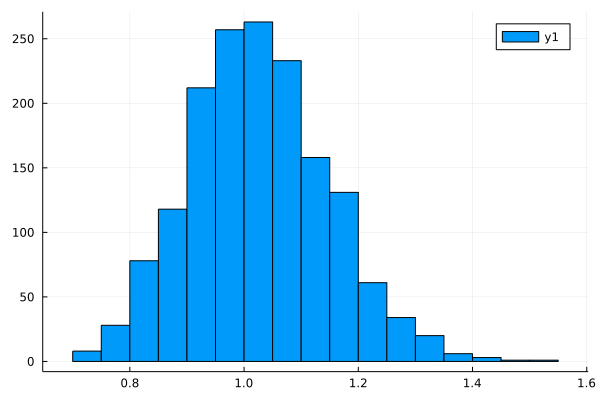

In [72]:
histogram(αs)

In [73]:
cal_mid_up_low(αs)

(1.0179097605577898, 0.21584254154525007, 0.18485592640603787)

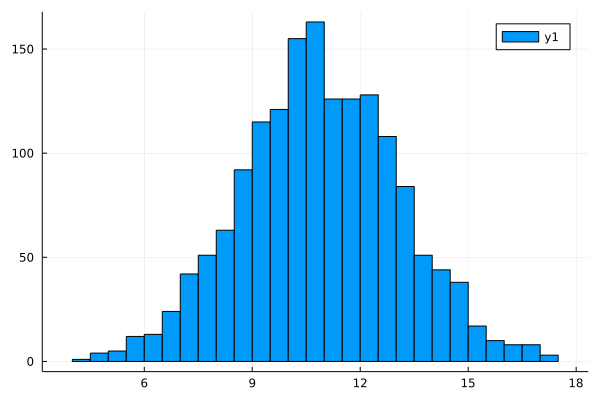

In [74]:
histogram(Mfs)

In [75]:
cal_mid_up_low(Mfs)

(10.838450953943044, 3.7283861831902794, 3.5752728646645773)

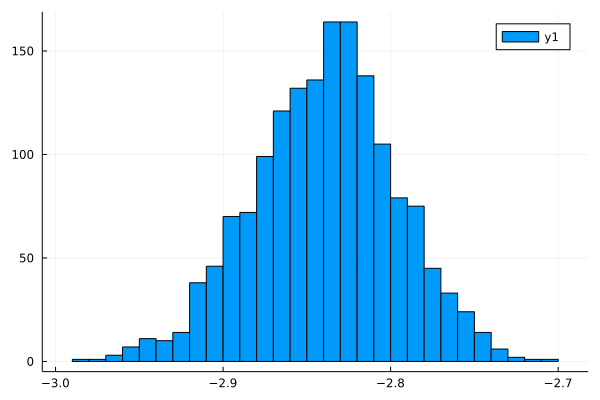

In [76]:
histogram(log_fpbhs)

In [77]:
cal_mid_up_low(10 .^ log_fpbhs .* 1e3)

(1.454493207249834, 0.24275679538496453, 0.22736548634261955)

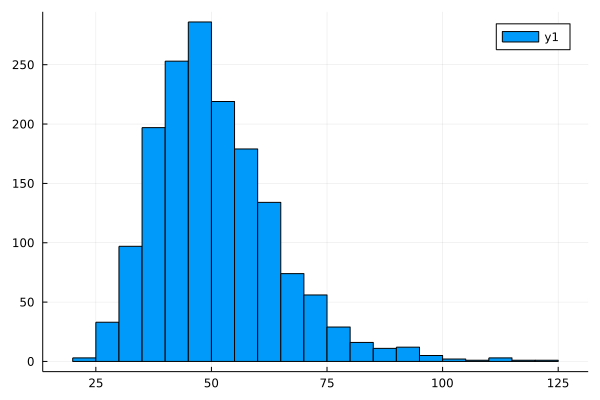

In [78]:
histogram(R12s)

In [79]:
cal_mid_up_low(R12s)

(48.84401411476029, 26.148962879020978, 15.855396727164234)

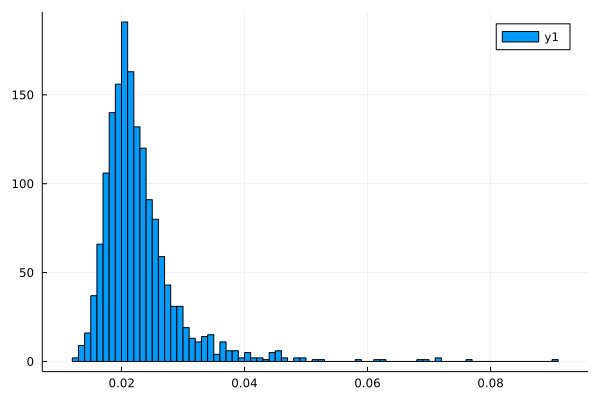

In [80]:
histogram(R2_to_R1s)

In [81]:
cal_mid_up_low(R2_to_R1s .* 1e2)

(2.1516446042155883, 1.2582536819687462, 0.5182183641122919)